In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import matplotlib.pyplot as plt
import cv2
import rasterio
import numpy as np
from satellitepy.data.labels import read_label
from satellitepy.data.tools import show_labels_on_images
from satellitepy.data.utils import read_img
from pathlib import Path
from satellitepy.data.patch import get_patches

# PIL.Image.MAX_IMAGE_PIXELS = 715538754

# Read an fr24 image and its label file

In [37]:
img_path = '/mnt/2tb-1/satellitepy/data/FR24_dataset/images/Amsterdam_23MAR14104929.TIF'
# img_path = '/home/murat/Projects/satellitepy/data/DOTA/datasplit/images/P0001__1__228___1848.png'

In [35]:
print(Path(img_path).is_file())

True


In [44]:
label_path = '/mnt/2tb-1/satellitepy/data/FR24_dataset/labels_fineair/role_th_50/Amsterdam_23MAR14104929.geojson'

In [ ]:

show_label_on_image(
    img_path=Path(img_path),
    label_path=Path(label_path),
    label_format='fr24',
    tasks=['obboxes'],
    img_read_module='rasterio',
    out_dir=Path('/home/murat/Projects/satellitepy/data/fr24/labels_on_images'))

In [14]:
gt_labels = read_label(label_path, label_format='fr24', mask_path=None)

In [38]:
img_cv_original = cv2.imread(img_path)

In [46]:
img_cv_original.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [40]:
# img = cv2.imread(img_path)
with rasterio.open(img_path) as src:
    # Read the image as a numpy array
    img = src.read()

    # Get image metadata
    metadata = src.meta
    print(img.shape)


## Create patches

In [48]:
img = read_img(str(img_path), module='rasterio', rescaling=1, interpolation_method=cv2.INTER_LINEAR)

gt_labels = read_label(label_path, label_format='fineair', mask_path=None, rescaling=1)

patches = get_patches(
            img,
            gt_labels,
            truncated_object_thr=0.2,
            patch_size=1024,
            patch_overlap=100
        )

/home/murat/Projects/satellitepy/venv_satellitepy/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [50]:
len(patches['images'])

858

In [4]:
metadata

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 23761,
 'height': 30114,
 'count': 4,
 'crs': CRS.from_epsg(32631),
 'transform': Affine(0.3, 0.0, 616243.5,
        0.0, -0.3, 5803318.5)}

In [22]:
img.shape

(4, 30114, 23761)

In [6]:

# img_cv = np.transpose(img, axes=(1, 2, 0)) # RGBA
img_cv = np.transpose(img, axes=(1, 2, 0))

In [7]:
img_cv.shape


(30114, 23761, 4)

In [7]:
img_cv_bgr = cv2.cvtColor(img_cv,cv2.COLOR_RGBA2BGR)

In [8]:
height, width = img_cv_bgr.shape[:2]

# Calculate the new dimensions
new_width = int(width * 0.2)
new_height = int(height * 0.2)

# Resize the image
img_cv_resized = cv2.resize(img_cv_bgr, (new_width, new_height))
img_cv_resized.shape

(6022, 4752, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


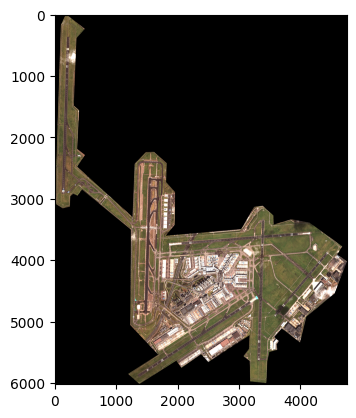

In [9]:
plt.imshow(img_cv_resized)

In [47]:
img_cv_resized_normalized = ((img_cv_resized/np.amax(img_cv_resized,axis=(0,1)))*255).astype(int)

In [53]:
img_cv_resized_standardized = (img_cv_resized-np.mean(img_cv_resized,axis=(0,1)))/np.std(img_cv_resized,axis=(0,1))#.astype(int)

In [10]:
np.amax(img_cv_resized,axis=(0,1))

array([1773, 1712, 2047], dtype=uint16)

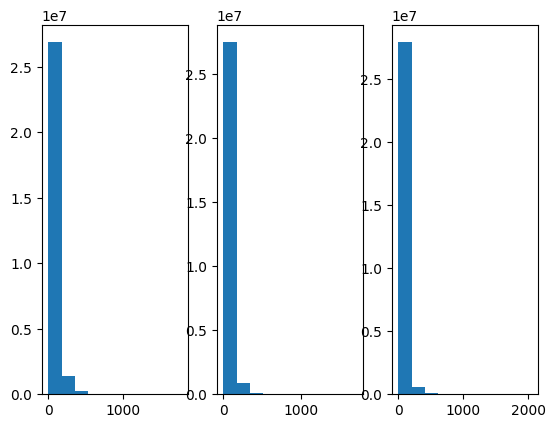

In [11]:
fig,axs = plt.subplots(1,3)
for i in range(3):  # Plot RGB channels
    axs[i].hist(img_cv_resized[:, :, i].flatten())
    

In [48]:
len(np.unique(img_cv_resized_normalized))

255

In [58]:
np.amax(img_cv_resized_standardized,axis=(0,1,2))

29.963196098160935

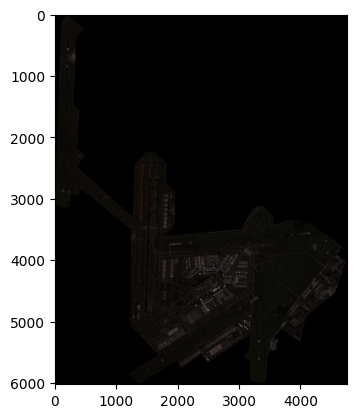

In [12]:
img_to_save = ((img_cv_resized / np.amax(img_cv_resized,axis=(0,1,2)))*255).astype(int)

plt.imshow(img_to_save)

In [61]:
cv2.imwrite('/home/murat/Projects/satellitepy/data/fr24/amsterdam_resized/Amsterdam_23MAR14104929.png',img_cv_resized_normalized)

True

(-0.5, 999.5, 999.5, -0.5)

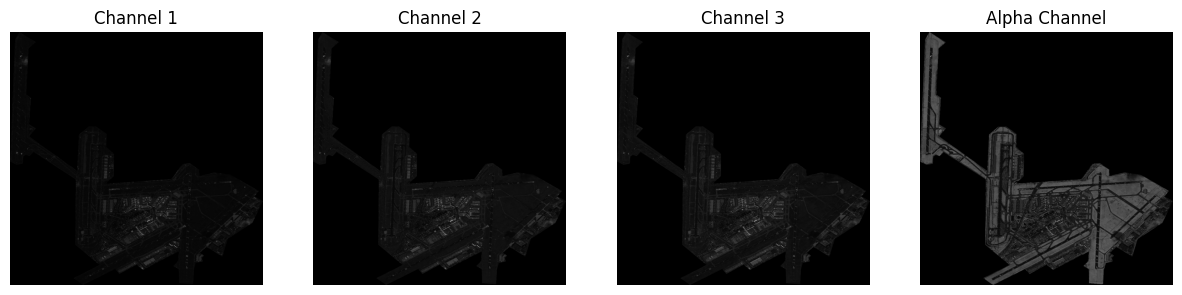

In [7]:
img_cv_resized = cv2.resize(img_cv, (1000, 1000))
# Display each channel in a subplot
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Plot each channel
for i in range(3):  # Plot RGB channels
    axs[i].imshow(img_cv_resized[:, :, i], cmap='gray')
    axs[i].set_title(f'Channel {i+1}')
    axs[i].axis('off')

# Plot the alpha channel
axs[3].imshow(img_cv_resized[:, :, 3], cmap='gray')
axs[3].set_title('Alpha Channel')
axs[3].axis('off')


In [8]:
height, width = img.shape[1:]

# Calculate the new dimensions
new_width = int(width * 0.2)
new_height = int(height * 0.2)

# Resize the image
resized_image = cv2.resize(img, (new_width, new_height))

# Save or display the resized image
# cv2.imwrite('resized_image.jpg', resized_image)
plt.imshow(resized_image*255)


error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:3699: error: (-215:Assertion failed) !dsize.empty() in function 'resize'


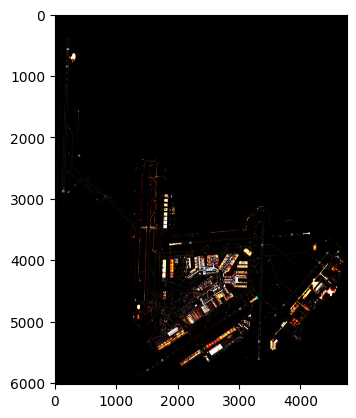

In [24]:

prediction_img_path = '/home/murat/Projects/satellitepy/data/fr24/amsterdam_resized/Amsterdam_23MAR14104929.png'
predicted_img = cv2.imread(prediction_img_path)
plt.imshow(predicted_img*255)

In [22]:
# lo - low value as percentile 0.1 (1/1000 of test values are below lo)
# hi - high value as percentile 99.9 (1/1000 of test values are above hi)
lo, hi = np.percentile(img_cv_resized, (1, 99))

# Apply linear "stretech" - lo goes to 0, and hi goes to 255
img_cv_resized_stretched = (img_cv_resized.astype(float) - lo) * (255/(hi-lo))

#Clamp range to [0, 255] and convert to uint8
# img_cv_resized_adjusted = np.maximum(np.minimum(img_cv_resized_stretched, 255), 0).astype(np.uint8)
img_cv_resized_adjusted = np.clip(img_cv_resized_stretched,0,255).astype(np.uint8)

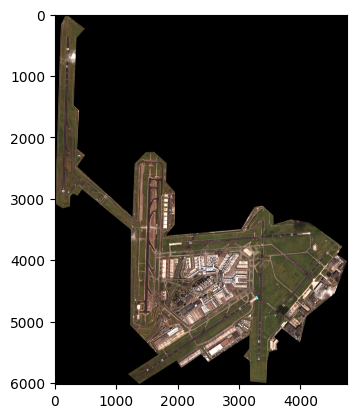

In [23]:
np.amax(img_cv_resized_adjusted)
plt.imshow(img_cv_resized_adjusted)

In [21]:
cv2.imwrite('/home/murat/Projects/satellitepy/data/fr24/amsterdam_resized/Amsterdam_23MAR14104929.png',img_cv_resized_adjusted)

True

# Temporary json files

In [ ]:
import os
import json

# Function to load a JSON file
def load_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Function to save a JSON file
def save_json(data, file_path):
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)

# Function to update JSON data
def update_json(data):
    if 'gt_labels' in data:
        data['gt_labels']['fineair-class'] = data['gt_labels'].pop('fine-class')
    return data

# Function to process JSON files in a folder
def process_json_files(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(input_folder):
        if filename.endswith('.json'):
            file_path = os.path.join(input_folder, filename)
            
            # Load the JSON file
            data = load_json(file_path)
            
            # Update the JSON data
            updated_data = update_json(data)
            
            # Save the updated JSON file to the output folder
            output_file_path = os.path.join(output_folder, filename)
            save_json(updated_data, output_file_path)
            print(f"Processed file: {filename}")

# Define input and output folders
input_folder = '/home/murat/Projects/satellitepy/exps/roi_trans_fineair/results/patch_labels'
output_folder = '/home/murat/Projects/satellitepy/exps/roi_trans_fineair/results/patch_labels_with_fineair'

# Process the JSON files
process_json_files(input_folder, output_folder)


# Remove non overlapping patch file labels

In [4]:
import os

# Function to get a set of filenames in a folder
def get_filenames(folder):
    return set(os.listdir(folder))

# Function to remove non-overlapping files
def remove_non_overlapping_files(folder1, folder2):
    # Get the sets of filenames in each folder
    filenames1 = get_filenames(folder1)
    filenames2 = get_filenames(folder2)
    
    # Find the overlapping filenames
    overlapping_filenames = filenames1 & filenames2
    
    # Remove non-overlapping files from folder1
    for filename in filenames1 - overlapping_filenames:
        file_path = os.path.join(folder1, filename)
        os.remove(file_path)
        print(f"Removed {file_path}")
    
    # Remove non-overlapping files from folder2
    for filename in filenames2 - overlapping_filenames:
        file_path = os.path.join(folder2, filename)
        os.remove(file_path)
        print(f"Removed {file_path}")

# Define the folders to compare
folder1 = '/mnt/2tb-1/satellitepy/data/FR24_patches/test/labels/'
folder2 = '/home/murat/Projects/satellitepy/exps/roi_trans_fineair/results/patch_labels'

# Remove non-overlapping files
remove_non_overlapping_files(folder1, folder2)


Removed /home/murat/Projects/satellitepy/exps/roi_trans_fineair/results/patch_labels/Singapore_22SEP27034737_x_2000_y_18000.json
Removed /home/murat/Projects/satellitepy/exps/roi_trans_fineair/results/patch_labels/Singapore_22SEP27034737_x_6500_y_8500.json
Removed /home/murat/Projects/satellitepy/exps/roi_trans_fineair/results/patch_labels/Singapore_22SEP27034737_x_6000_y_9500.json
Removed /home/murat/Projects/satellitepy/exps/roi_trans_fineair/results/patch_labels/Singapore_22SEP27034737_x_6000_y_14000.json
Removed /home/murat/Projects/satellitepy/exps/roi_trans_fineair/results/patch_labels/Singapore_22SEP27034737_x_7000_y_13500.json
Removed /home/murat/Projects/satellitepy/exps/roi_trans_fineair/results/patch_labels/Singapore_22SEP27034737_x_5000_y_11500.json
Removed /home/murat/Projects/satellitepy/exps/roi_trans_fineair/results/patch_labels/Singapore_22SEP27034737_x_4000_y_16000.json
Removed /home/murat/Projects/satellitepy/exps/roi_trans_fineair/results/patch_labels/Singapore_22SE

# Convert fineair classes in dota label files into CGC

In [2]:
from satellitepy.utils.path_utils import get_file_paths
from pathlib import Path
from satellitepy.data.labels import read_label

set_name = 'val'

label_folder = Path(f'/mnt/2tb-1/satellitepy/data/FR24_patches/ps_1024_balanced_sets/{set_name}/labels/')
label_paths = get_file_paths(label_folder)

out_label_folder = Path(f'/mnt/2tb-1/satellitepy/data/FR24_patches/ps_1024_balanced_sets/{set_name}/labels_dota_cgc/')


for label_path in label_paths:
    out_label_path = out_label_folder / f"{label_path.stem}.txt"
    f_out = open(out_label_path,'w+')
    label = read_label(label_path=label_path,label_format='satellitepy')
    obboxes = label['obboxes']
    for i, obbox in enumerate(obboxes):
        # fineair_class = label['fineair-class'][i]

        fineair_class = label['coarse-class'][i]
        # if fineair_class == 'Private Jet':
            # print(label_path)
        fineair_class = fineair_class.replace(' ', '-')
        obbox_1d = [str(corner) for obbox_corners in obbox for corner in obbox_corners]
        cgc_bbox_line = ' '.join(obbox_1d) + ' ' + str(fineair_class) + ' ' + '0' + '\n'
        # print(cgc_bbox_line)
        f_out.write(cgc_bbox_line)

    # if count > 2:
        # print(label_path)
    f_out.close()
    
